# Problem Set 3: GMM
## Author: Ling Dai

In [368]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

## 1(a)

<IPython.core.display.Javascript object>


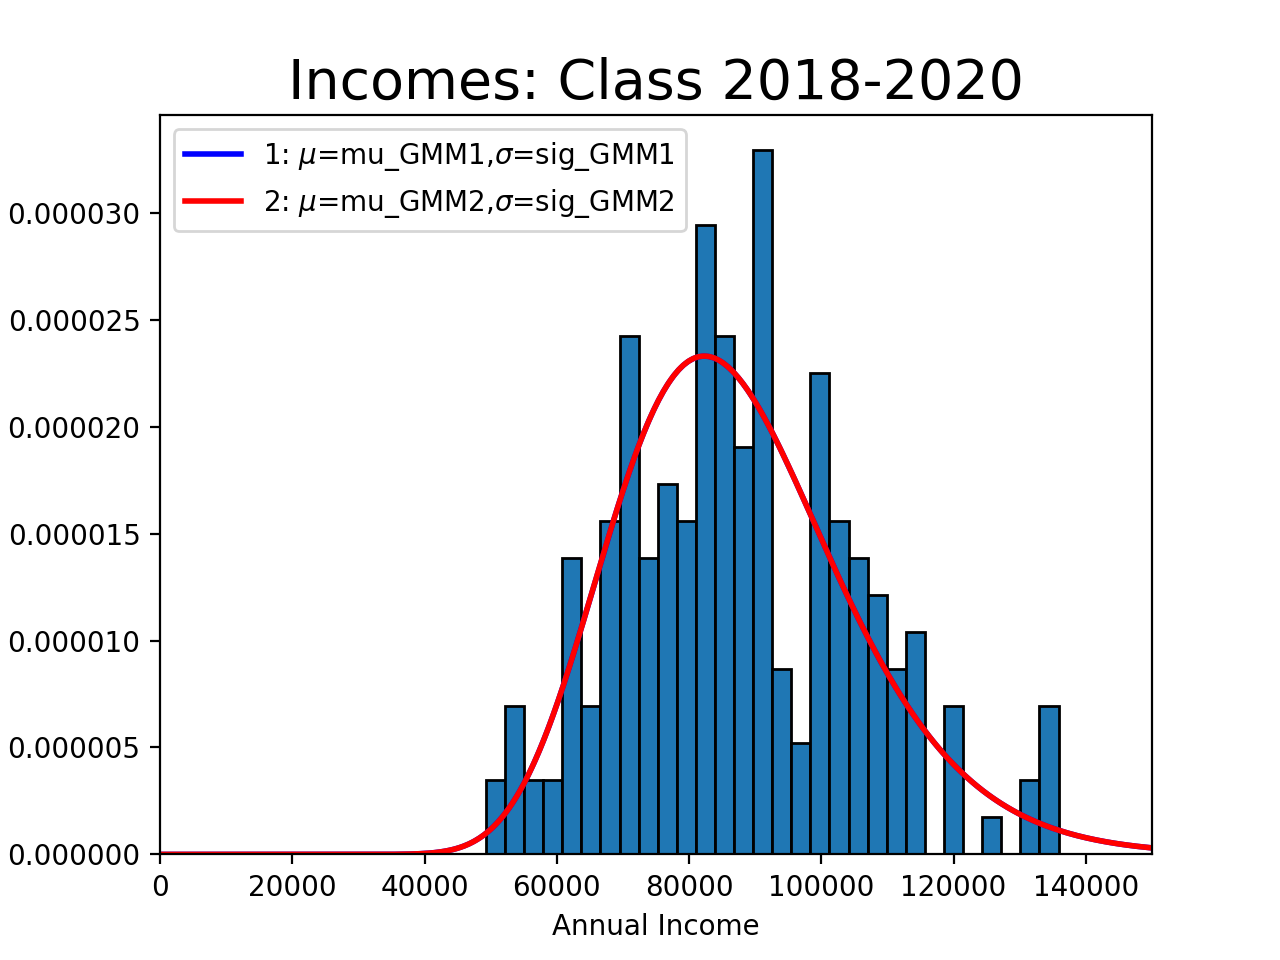

(0, 150000)

In [369]:
#Import income data
incomes = np.loadtxt('incomes.txt')

count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Incomes: Class 2018-2020', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent of scores')
plt.xlim([0, 150000])

## 1(b)

In [370]:
#Define data/model moments, the error vector, and the criterion function

def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and standard
    deviation sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the log-normally distributed random
             variable
    mu     = scalar, mean of the log-normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log-normally distributed
             random variable
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''

    pdf_vals = sts.lognorm.pdf(xvals, s = sigma, scale = np.exp(mu))
    
    return pdf_vals


def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    #integrate from 0 to 200,000 and then from 200,000 to inf to force intgr.quad to
    #detect the peak of lognormal pdf function
    
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma)
    mean_model = intgr.quad(xfx, 0, 200000)[0] + intgr.quad(xfx, 200000, np.inf)[0]
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma)
    var_model = intgr.quad(x2fx, 0, 200000)[0] + intgr.quad(x2fx, 200000, np.inf)[0]
    
    return mean_model, var_model


def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)[0,0]
    return crit_val

In [371]:
#Estimate parameters using GMM

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
results

      fun: 1.64870589388603e-13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.84566741e-07, -4.64135780e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 10
   status: 0
  success: True
        x: array([11.3596468 ,  0.20378126])

In [372]:
#Plot your estimated lognormal PDF against the histogram from part (a).
mu_GMM1, sig_GMM1 = results.x

#Report the value of your GMM criterion function at the estimated parameter values.
#Report and compare your two data moments against your two model moments at the estimated parameter values.
dist_pts = np.linspace(1e-10, 150000, 200)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='b', label='1: $\mu$=mu_GMM1,$\sigma$=sig_GMM1')
plt.legend(loc='upper left')


print('mu_GMM1: {}, sig_GMM1: {}'.format(mu_GMM1,sig_GMM1))
print('The value of the GMM criterion function is {}'.format(results.fun))
print('Data: mean {}, standard deviation {}'.format(data_moments(incomes)[0],data_moments(incomes)[1]**(0.5)))
print('Model: mean {}, standard deviation {}'.format(
      model_moments(mu_GMM1, sig_GMM1)[0],model_moments(mu_GMM1, sig_GMM1)[1]**(0.5)))

mu_GMM1: 11.3596467997, sig_GMM1: 0.203781264125
The value of the GMM criterion function is 1.64870589389e-13
Data: mean 87588.9307685, standard deviation 18035.9068271
Model: mean 87588.9564868, standard deviation 18035.904298


## 1(c)

In [373]:
#Calculate W_hat2
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[ 6.34352754e+14 -6.05898134e+14]
 [-6.05898134e+14  5.78719879e+14]]


In [374]:
#Perform 2-step GMM estimator

params_init = np.array([mu_GMM1, sig_GMM1])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (incomes, W_hat2*1e-14)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
results #no significant improvement

      fun: 1.4805138860252975e-14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.05366967e-07,  5.79311553e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([11.3596468 ,  0.20378132])

In [375]:
#Plot your estimated lognormal PDF against the histogram from part (a),(b).
mu_GMM2, sig_GMM2 = results.x

#Report the value of your GMM criterion function at the estimated parameter values.
#Report and compare your two data moments against your two model moments at the estimated parameter values.
dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2),
         linewidth=2, color='r', label='2: $\mu$=mu_GMM2,$\sigma$=sig_GMM2')
plt.legend(loc='upper left')

print('mu_GMM2: {}, sig_GMM2: {}'.format(mu_GMM2,sig_GMM2))
print('The value of the GMM criterion function is {}'.format(results.fun))
print('Data: mean {}, standard deviation {}'.format(data_moments(incomes)[0],data_moments(incomes)[1]**(0.5)))
print('Model: mean {}, standard deviation {}'.format(
      model_moments(mu_GMM2, sig_GMM2)[0],model_moments(mu_GMM2, sig_GMM2)[1]**(0.5)))

mu_GMM2: 11.359646805, sig_GMM2: 0.203781316236
The value of the GMM criterion function is 1.48051388603e-14
Data: mean 87588.9307685, standard deviation 18035.9068271
Model: mean 87588.9578796, standard deviation 18035.9092934


Because the 2-step parameters are too close the parameters generated in 1(b), the two plotted pdf curves are not visually differentiable from each other. Similar to 1(b), the two moments generated by our 2-step estimator model is very close to the data moments.

## 1(d)

In [376]:
def data_moments_new(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    perc_below75k = scalar, percent of individuals who earn less than $75,000
    perc_75to100k  = scalar, percent of individuals who earn between $75,000
                     and $100,000
    perc_above100k = scalar, percent of individuals who earn more than $100,000
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    total_num = float(len(xvals)) #use float() to ensure it works in Python 2.7
    perc_below75k = ((xvals < 75000).sum())/total_num
    perc_75to100k = ((xvals >= 75000)&(xvals <= 100000)).sum()/total_num
    perc_above100k = ((xvals > 100000).sum())/total_num
    
    return perc_below75k, perc_75to100k, perc_above100k


def model_moments_new(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    fx = lambda x: sts.lognorm.pdf(x, s = sigma, scale = np.exp(mu))
    perc_below75k = intgr.quad(fx, 0, 75000)[0]
    perc_75to100k = intgr.quad(fx, 75000, 100000)[0]
    perc_above100k = intgr.quad(fx, 100000, 300000)[0]+intgr.quad(fx, 300000, np.inf)[0]
    
    return perc_below75k, perc_75to100k, perc_above100k

def err_vec_new(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    perc_below75k, perc_75to100k, perc_above100k = data_moments_new(xvals)
    moms_data = np.array([[perc_below75k], [perc_75to100k], [perc_above100k]])
    mperc_below75k, mperc_75to100k, mperc_above100k = model_moments_new(mu, sigma)
    moms_model = np.array([[mperc_below75k], [mperc_75to100k], [mperc_above100k]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion_new(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec_new(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)[0,0]
    
    return crit_val

In [377]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat_3 = np.eye(3)
gmm_args = (incomes, W_hat_3)
results = opt.minimize(criterion_new, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
results

      fun: 3.973551611021124e-13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.56739026e-06, -4.08590075e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 10
   status: 0
  success: True
        x: array([11.367349  ,  0.22628048])

<IPython.core.display.Javascript object>


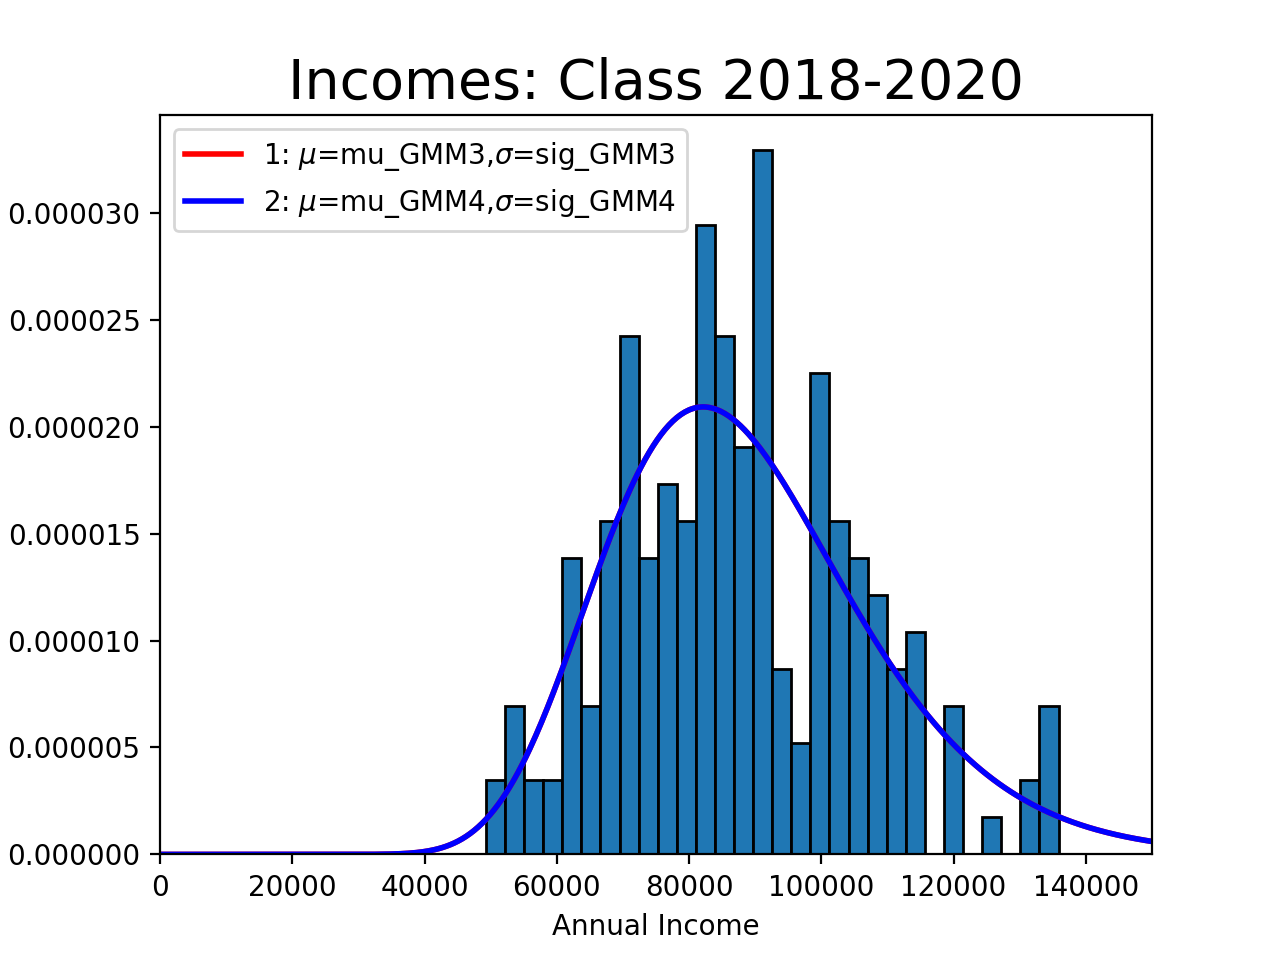

(0, 150000)

In [378]:
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Incomes: Class 2018-2020', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent of scores')
plt.xlim([0, 150000])

In [379]:
mu_GMM3, sig_GMM3 = results.x

dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=2, color='r', label='1: $\mu$=mu_GMM3,$\sigma$=sig_GMM3')
plt.legend(loc='upper left')

In [380]:
print('mu_GMM3: {}, sig_GMM3: {}\n'.format(mu_GMM3,sig_GMM3)) #Report estimates
print('The value of the GMM criterion function is {}\n'.format(results.fun))
print('Data:\n percent below 75k: {}\n percent between 75k and 100k: {}\n percent above 100k: {}\n'
      .format(data_moments_new(incomes)[0],data_moments_new(incomes)[1],data_moments_new(incomes)[2]))
print('Model:\n percent below 75k: {}\n percent between 75k and 100k: {}\n percent above 100k: {}\n'
      .format(model_moments_new(mu_GMM3,sig_GMM3)[0],
              model_moments_new(mu_GMM3,sig_GMM3)[1],
              model_moments_new(mu_GMM3,sig_GMM3)[2]))
print("The two moments generated by our model is very close to the data moments.")

mu_GMM3: 11.3673489987, sig_GMM3: 0.226280477003

The value of the GMM criterion function is 3.97355161102e-13

Data:
 percent below 75k: 0.265
 percent between 75k and 100k: 0.475
 percent above 100k: 0.26

Model:
 percent below 75k: 0.264999847026
 percent between 75k and 100k: 0.475000097145
 percent above 100k: 0.260000038826

The two moments generated by our model is very close to the data moments.


## 1(e)

In [381]:
#Calculate W_hat4
err1_4 = err_vec_new(incomes, mu_GMM3, sig_GMM3, False)
VCV2_4 = np.dot(err1_4, err1_4.T) / incomes.shape[0]
W_hat2_4 = lin.pinv(VCV2_4)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_4)

[[ 4.22099922e+14 -1.49544309e+14 -1.09191977e+14]
 [-1.49544309e+14  5.29815315e+13  3.86852445e+13]
 [-1.09191977e+14  3.86852445e+13  2.82466003e+13]]


In [382]:
#Perform 2-step GMM estimator
params_init = np.array([mu_GMM3, sig_GMM3])

gmm_args = (incomes, W_hat2_4)
results = opt.minimize(criterion_new, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
results

      fun: 1.7749770970412575e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.99709832e+08, 6.41728209e+07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 3
   status: 0
  success: True
        x: array([11.36734892,  0.22628052])

In [383]:
mu_GMM4, sig_GMM4 = results.x

dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=2, color='b', label='2: $\mu$=mu_GMM4,$\sigma$=sig_GMM4')
plt.legend(loc='upper left')

In [384]:
print('mu_GMM4: {}, sig_GMM4: {}\n'.format(mu_GMM4,sig_GMM4)) #Report estimates
print('The value of the GMM criterion function is {}\n'.format(results.fun))
print('Data:\n percent below 75k: {}\n percent between 75k and 100k: {}\n percent above 100k: {}\n'
      .format(data_moments_new(incomes)[0],data_moments_new(incomes)[1],data_moments_new(incomes)[2]))
print('Model:\n percent below 75k: {}\n percent between 75k and 100k: {}\n percent above 100k: {}\n'
      .format(model_moments_new(mu_GMM4,sig_GMM4)[0],
              model_moments_new(mu_GMM4,sig_GMM4)[1],
              model_moments_new(mu_GMM4,sig_GMM4)[2]))
print("The two moments generated by our model is very close to the data moments.")

mu_GMM4: 11.3673489212, sig_GMM4: 0.226280516646

The value of the GMM criterion function is 1.77497709704e-05

Data:
 percent below 75k: 0.265
 percent between 75k and 100k: 0.475
 percent above 100k: 0.26

Model:
 percent below 75k: 0.26499999527
 percent between 75k and 100k: 0.475000023459
 percent above 100k: 0.259999964267

The two moments generated by our model is very close to the data moments.


As the results shows, the estimated model in 1(e) is not significantly different from the model in 1(d).

## 1(f)

Because the estimated coefficients in (b), (c), (d) and (e) are extremely close and hardly visually differentiable, it is very hard to tell which model is better. However, simply based on the value of the GMM criterion function, model in 1(b) would be the best, because it has the lowest GMM criterion function value.

## 2(a)

In [385]:
#import sick data
import pandas as pd
sickDF = pd.read_csv('sick.txt', header = 0)

In [386]:
def model_moments_sick(age, children, avgtemp_winter, Betas):
    
    beta0, beta1, beta2, beta3 = Betas
    m_sick = beta0 + beta1*age + beta2*children + beta3*avgtemp_winter
    return m_sick

def err_vec_sick(d_sick, age, children, avgtemp_winter, Betas):
    
    m_sick = model_moments_sick(age, children, avgtemp_winter, Betas)
    err_vec = m_sick - d_sick
    
    return err_vec

def criterion_sick(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (5,) vector
    args   = length 4 tuple, (d_sick, age, children, avgtemp_winter)
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (200, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    Betas= params
    d_sick, age, children, avgtemp_winter  = args
    err = err_vec_sick(d_sick, age, children, avgtemp_winter, Betas)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [387]:
params_init = np.array([1,1,1,1])
W = np.eye(200)
args = (sickDF['sick'],sickDF['age'],sickDF['children'],sickDF['avgtemp_winter'])
a = (args)
results = opt.minimize(criterion_sick, params_init, args = (a), method='BFGS')

In [388]:
results

      fun: 0.0018212901314508749
 hess_inv: array([[ 0.05280017,  0.00043398, -0.00904356, -0.00119908],
       [ 0.00043398,  0.0002267 , -0.00202797, -0.00014215],
       [-0.00904356, -0.00202797,  0.0208239 ,  0.00128675],
       [-0.00119908, -0.00014215,  0.00128675,  0.0001096 ]])
      jac: array([-3.37835809e-06,  1.05702915e-04,  1.77107140e-05, -5.05310309e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 564
      nit: 7
     njev: 92
   status: 2
  success: False
        x: array([ 0.25164615,  0.01293334,  0.40050217, -0.00999167])

In [389]:
beta_0, beta_1, beta_2, beta_3 = results.x
print("The estimated coefficients are:\n")
print(" beta_0 = {}\n beta_1 = {}\n beta_2 = {}\n beta_3 = {}\n".format(
      beta_0, beta_1, beta_2, beta_3))

print("The value of GMM criterion function at the estimated parameter values is {}\n".format(results.fun))

The estimated coefficients are:

 beta_0 = 0.251646151522
 beta_1 = 0.0129333438072
 beta_2 = 0.400502168292
 beta_3 = -0.00999166675895

The value of GMM criterion function at the estimated parameter values is 0.00182129013145

